In [1]:
%load_ext autotime

time: 339 µs (started: 2021-12-06 13:49:48 +01:00)


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from bs4 import BeautifulSoup
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
from sklearn.metrics import confusion_matrix
warnings.simplefilter(action='ignore', category=Warning)
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from tqdm import tqdm
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

time: 2.63 s (started: 2021-12-06 13:49:48 +01:00)


# 1 - Import ----------------------------------------

In [3]:
lst = []
#for i in range (1,11):
for i in range (1,3):
    path = 'Data/Query_'+ str(i) + '.csv'
    mDf = pd.read_csv(path, dtype=str) 
    mDf = mDf[['Tags', 'Body']]
    lst.append(mDf)

time: 1.54 s (started: 2021-12-06 13:49:51 +01:00)


In [4]:
mDf = pd.concat(lst, ignore_index=True)
mDf = mDf[mDf['Tags'].notna()]
print(mDf.shape)
mDf_Body = pd.DataFrame(mDf['Body'])
mDf_Tags = pd.DataFrame(mDf['Tags'])

(20732, 2)
time: 27.3 ms (started: 2021-12-06 13:49:53 +01:00)


# 2 - Cleaning ----------------------------------------

# 2.1 Body
### 2.1.1 HTML ---> To String
### 2.1.2 Minuscule 
### 2.1.3 - Caractere non viable 
### 2.1.4 - Chiffre
### 2.1.5 - Ponctuation 
### 2.1.6 - Lemmatize
### 2.1.7 - StopWord

In [5]:
mDf_Body['string_in_HTML']=mDf_Body.apply(lambda x: BeautifulSoup(x['Body']).get_text().replace('\n',' '),axis=1)
mDf_Body = pd.DataFrame(mDf_Body['string_in_HTML'])
mDf_Body.head(2)

,string_in_HTML
0,This question intends to be technology-agnosti...
1,"In Python, what are metaclasses and what do we..."


time: 10 s (started: 2021-12-06 13:49:53 +01:00)


In [6]:
import pandas as pd
import numpy as np
import string

import sys
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

def data_preprocess(dataframe,xXx, lower=True, ascii_chars=True, no_numbers=True, no_punctuation=True, remove_stopwords=True, lemmatize=True, custom_blank_text='non ascii symbols punctuations numbers'):
    # Minuscule
    if lower == True:
        dataframe['Query_Modified'] = dataframe[xXx].str.lower()
    
    # Caractere non viable
    if ascii_chars == True:                            
        dataframe["Query_Modified"] = dataframe["Query_Modified"].apply(lambda x: ''.join([" " if i not in string.printable else i for i in x]))
    
    # Retire chiffre
    if no_numbers == True:
        dataframe['Query_Modified'] = dataframe['Query_Modified'].str.replace(r'\d', '')
    
    #Ponctuation
    if no_punctuation == True:
        dataframe['Query_Modified'] = dataframe['Query_Modified'].str.replace(r'[^\w\s]+', ' ')
    
    # Retire Stopwords
    if remove_stopwords == True:
        stop = stopwords.words('english')
        
        dataframe['Query_Modified'] = dataframe['Query_Modified'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    
    #Lemmatize
    if lemmatize == True:
        wnl = WordNetLemmatizer()
        def lemmatize_all(sentence):
            text = list()
            for word, tag in nltk.pos_tag(str.split(sentence)):
                if tag.startswith("NN"):
                    text.append( wnl.lemmatize(word, pos='n'))
                elif tag.startswith('VB'):
                    text.append( wnl.lemmatize(word, pos='v'))
                elif tag.startswith('JJ'):
                    text.append( wnl.lemmatize(word, pos='a'))
                else:
                    text.append( word)
            return ' '.join(text)            

        dataframe['Query_Modified'] = dataframe['Query_Modified'].apply(lambda sentence: ' '.join([lemmatize_all(sentence)]))
    
    #Replacing blanks from ascii characters, punctuations and numbers with custom text
    dataframe['Query_Modified'].replace(r'^\s*$', custom_blank_text, regex=True, inplace = True)
    
    #Extra Spaces
    dataframe['Query_Modified'] = dataframe['Query_Modified'].apply(lambda x: re.sub("\s\s+", " ", str(x.strip())))
    
    print('Done')
    
    return dataframe


time: 345 ms (started: 2021-12-06 13:50:03 +01:00)


In [7]:
data = data_preprocess(mDf_Body, 'string_in_HTML', lower=True, ascii_chars=True, no_numbers=True, no_punctuation=True, remove_stopwords=True, lemmatize=False, custom_blank_text='non ascii symbols punctuations numbers')
data

Done


,string_in_HTML,Query_Modified
0,This question intends to be technology-agnosti...,question intends technology agnostic kind web ...
1,"In Python, what are metaclasses and what do we...",python metaclasses use
3,When logging with Log4Net it's very easy to pu...,logging lognet easy put class called log log f...
19,How can I make a Facebook RSS application that...,make facebook rss application autoupdates prov...
22,What is a good regular expression that can val...,good regular expression validate text string m...
...,...,...
99979,I have a DataTrigger defined in my XAML which ...,datatrigger defined xaml want use several plac...
99983,I'm starting a new application and looking at ...,starting new application looking using orm par...
99987,I've been doing some socket programming to tra...,socket programming transmit information across...
99991,I'm not looking for the whole ACO-ARO implemen...,looking whole aco aro implementation want use ...


time: 8.74 s (started: 2021-12-06 13:50:03 +01:00)


# 2.2 Tags
### 2.2.1 HTML ---> To String
### 2.2.2 Minuscule 
### 2.2.3 - Caractere non viable 
### 2.2.4 - Chiffre
### 2.2.5 - Ponctuation 
### 2.2.6 - Lemmatize
### 2.2.7 - StopWord

In [8]:
mDf_Tags_1 = mDf_Tags.copy()
mDf_Tags_1['Tags'] = mDf_Tags_1['Tags'].str.replace(r'><', ' ')
mDf_Tags_1['Tags'] = mDf_Tags_1['Tags'].str.replace(r'<', '')
mDf_Tags_1['Tags'] = mDf_Tags_1['Tags'].str.replace(r'>', '')
mDf_Tags_2 = data_preprocess(mDf_Tags_1, 'Tags', lower=True, ascii_chars=True, no_numbers=True, no_punctuation=True, remove_stopwords=True, lemmatize=True, custom_blank_text='non ascii symbols punctuations numbers')
mDf_Tags_2.pop('Tags')
mDf_Tags_2= mDf_Tags_2.rename(columns={'Query_Modified': "Tags"})
mDf_Tags_2 = mDf_Tags_2.reset_index()
mDf_Tags_2.pop('index')
mDf_Tags_2

Done


,Tags
0,web framework
1,python oop metaclass python class python datam...
2,c log enterprise library application block
3,php facebook r
4,c regex
...,...
20727,net wpf xaml datatrigger
20728,python orm sqlalchemy
20729,java dataoutputstream
20730,php authentication cakephp cakephp


time: 13.4 s (started: 2021-12-06 13:50:12 +01:00)


# 3 Concat Body + Tags

In [75]:
result = pd.concat([data, mDf_Tags_1], axis=1, ignore_index=True)
result_1 = result[[1,2]]
result_1 = result_1.rename(columns={1: "Sentence", 2:'Labels'})
new_df = result_1.copy()
new_df

,Sentence,Labels
0,question intends technology agnostic kind web ...,web framework
1,python metaclasses use,python oop metaclass python class python datam...
3,logging lognet easy put class called log log f...,c log enterprise library application block
19,make facebook rss application autoupdates prov...,php facebook r
22,good regular expression validate text string m...,c regex
...,...,...
99979,datatrigger defined xaml want use several plac...,net wpf xaml datatrigger
99983,starting new application looking using orm par...,python orm sqlalchemy
99987,socket programming transmit information across...,java dataoutputstream
99991,looking whole aco aro implementation want use ...,php authentication cakephp cakephp


time: 1.3 s (started: 2021-12-06 14:35:23 +01:00)


In [76]:
df_lab = pd.DataFrame(new_df['Labels'])
df_lab = df_lab.T

from collections import OrderedDict

new_r = []
for i in tqdm(df_lab.columns):
    s = df_lab[i].values[0]
    t = ' '.join(OrderedDict((w,w) for w in s.split()).keys())
    new_r.append(t)
    
    
new_r_df = pd.DataFrame(new_r)

new_r_df = new_r_df.rename(columns={0: "New_Tags"})
new_r_df

100%|██████████| 20732/20732 [00:01<00:00, 13796.09it/s]


,New_Tags
0,web framework
1,python oop metaclass class datamodel
2,c log enterprise library application block
3,php facebook r
4,c regex
...,...
20727,net wpf xaml datatrigger
20728,python orm sqlalchemy
20729,java dataoutputstream
20730,php authentication cakephp


time: 2.46 s (started: 2021-12-06 14:35:24 +01:00)


In [77]:
new_r_df["tag_count"] = new_r_df["New_Tags"].apply(lambda x : len(x.split()))
new_r_df

,New_Tags,tag_count
0,web framework,2
1,python oop metaclass class datamodel,5
2,c log enterprise library application block,6
3,php facebook r,3
4,c regex,2
...,...,...
20727,net wpf xaml datatrigger,4
20728,python orm sqlalchemy,3
20729,java dataoutputstream,2
20730,php authentication cakephp,3


time: 52.9 ms (started: 2021-12-06 14:35:27 +01:00)


In [82]:
print( "Maximum number of tags in a question: ", new_r_df["tag_count"].max())
print( "Minimum number of tags in a question: ", new_r_df["tag_count"].min())
print( "Average number of tags in a question: ", new_r_df["tag_count"].mean())

Maximum number of tags in a question:  10
Minimum number of tags in a question:  1
Average number of tags in a question:  3.4789697086629365
time: 3.24 ms (started: 2021-12-06 14:37:23 +01:00)


In [94]:
val_count = pd.DataFrame(new_r_df['tag_count'].value_counts())
sum_ = val_count['tag_count'].sum()
print(sum_)
val_count['Sum'] = sum_
val_count['Perc'] = val_count['tag_count'] / val_count['Sum']*100
val_count = val_count.reset_index()
val_count = val_count.rename(columns={'index': "Nb_Words"})
val_count = val_count.sort_values(by=['Nb_Words'])
val_count

20732


,Nb_Words,tag_count,Sum,Perc
4,1,1441,20732,6.950608
2,2,4191,20732,20.215126
0,3,5550,20732,26.770210
1,4,4671,20732,22.530388
3,5,3025,20732,14.590970
5,6,1301,20732,6.275323
6,7,414,20732,1.996913
7,8,113,20732,0.545051
8,9,24,20732,0.115763
9,10,2,20732,0.009647


time: 24.4 ms (started: 2021-12-06 14:45:40 +01:00)


Text(0.5, 1.0, 'Nb Tags / Question')

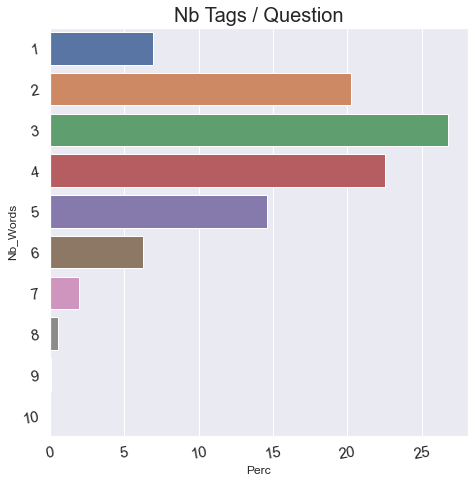

time: 328 ms (started: 2021-12-06 14:45:53 +01:00)


In [95]:
plt.figure(figsize=(7.5, 7.5))
ax = sns.barplot(x='Perc', y='Nb_Words', data=val_count, orient='h')
plt.xticks(fontsize=15, rotation=10)
plt.yticks(fontsize=15, rotation=10)
plt.title('Nb Tags / Question', fontsize=20)

# Nombre de Tags unique

In [101]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_bow = vectorizer.fit_transform(new_r_df['New_Tags'])

time: 148 ms (started: 2021-12-06 14:49:28 +01:00)


In [102]:
print("Number of questions :", tag_bow.shape[0])
print("Number of unique tags :", tag_bow.shape[1])

Number of questions : 20732
Number of unique tags : 4812
time: 1.41 ms (started: 2021-12-06 14:49:29 +01:00)


In [103]:
tags = vectorizer.get_feature_names()
print("Few tags :", tags[30:50])

Few tags : ['actionmailer', 'actionscript', 'actionview', 'activation', 'activator', 'active', 'activemq', 'activeperl', 'activerecord', 'activereports', 'activeresource', 'activescaffold', 'activestate', 'activesync', 'activetcl', 'activex', 'activity', 'actor', 'acyclic', 'ad']
time: 4.67 ms (started: 2021-12-06 14:49:31 +01:00)


# Frequence des mots

In [105]:
freq = tag_bow.sum(axis=0).A1
tag_to_count_map = dict(zip(tags, freq))
list = []
for key, value in tag_to_count_map.items():
    list.append([key, value]) 
    
tag_df = pd.DataFrame(list, columns=['Tags', 'Counts'])
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_df_sorted

,Tags,Counts
455,c,4256
2660,net,3928
2028,java,1645
195,asp,1612
3880,sql,1497
...,...,...
2285,localsystem,1
2287,locbaml,1
2291,logarithm,1
2292,logcxx,1


time: 27.7 ms (started: 2021-12-06 14:50:38 +01:00)


# Distribution Totale

Text(0, 0.5, 'Frequency')

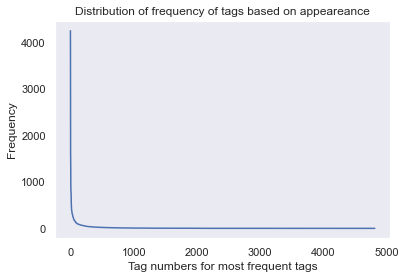

time: 268 ms (started: 2021-12-06 14:51:03 +01:00)


In [106]:
plt.plot(tag_df_sorted['Counts'].values)
plt.grid()
plt.title("Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")

# Distribution des 100 premiers mots

Text(0, 0.5, 'Frequency')

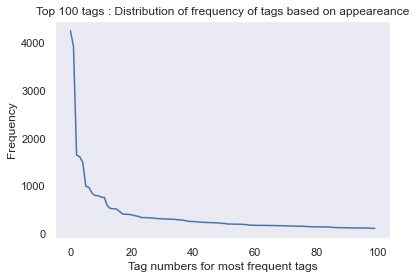

time: 259 ms (started: 2021-12-06 14:52:06 +01:00)


In [107]:
plt.plot(tag_df_sorted['Counts'][0:100].values)
plt.grid()
plt.title("Top 100 tags : Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")

# Distribution en quantiles

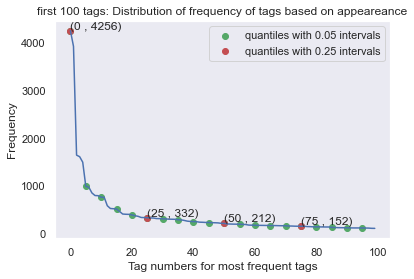

time: 370 ms (started: 2021-12-06 14:53:03 +01:00)


In [108]:
plt.plot(tag_df_sorted['Counts'][0:100].values)
plt.scatter(x=np.arange(0,100,5), y=tag_df_sorted['Counts'][0:100:5], c='g', label="quantiles with 0.05 intervals")
plt.scatter(x=np.arange(0,100,25), y=tag_df_sorted['Counts'][0:100:25], c='r', label = "quantiles with 0.25 intervals")
for x,y in zip(np.arange(0,100,25), tag_df_sorted['Counts'][0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.01, y+30))

plt.title('first 100 tags: Distribution of frequency of tags based on appeareance')
plt.grid()
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")
plt.legend()

# Distrib

Text(0.5, 1.0, 'Distribution')

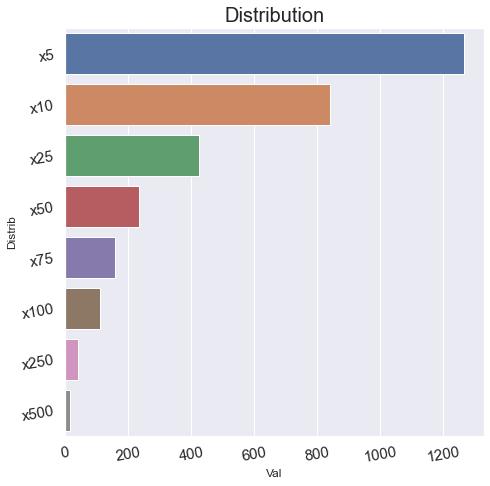

time: 322 ms (started: 2021-12-06 15:09:46 +01:00)


In [133]:
_5_fois   = tag_df_sorted[tag_df_sorted["Counts"]>5].shape[0]
_10_fois  = tag_df_sorted[tag_df_sorted["Counts"]>10].shape[0]
_25_fois  = tag_df_sorted[tag_df_sorted["Counts"]>25].shape[0]
_50_fois  = tag_df_sorted[tag_df_sorted["Counts"]>50].shape[0]
_75_fois  = tag_df_sorted[tag_df_sorted["Counts"]>75].shape[0]
_100_fois = tag_df_sorted[tag_df_sorted["Counts"]>100].shape[0]
_250_fois = tag_df_sorted[tag_df_sorted["Counts"]>250].shape[0]
_500_fois = tag_df_sorted[tag_df_sorted["Counts"]>500].shape[0]

lst = [['x5', _5_fois], ['x10', _10_fois], ['x25', _25_fois], ['x50', _50_fois],['x75', _75_fois],['x100', _100_fois], ['x250', _250_fois],['x500', _500_fois]]

lst_Df = pd.DataFrame(lst)
lst_Df= lst_Df.rename(columns={0: "Distrib", 1:'Val'})

plt.figure(figsize=(7.5, 7.5))
ax = sns.barplot(x='Val', y='Distrib', data=lst_Df, orient='h')
plt.xticks(fontsize=15, rotation=10)
plt.yticks(fontsize=15, rotation=10)
plt.title('Distribution', fontsize=20)

# Nb de Tags reprente 50% - 75%

In [174]:
tag_df_sorted_1 = tag_df_sorted.copy()
_sum_ = tag_df_sorted_1['Counts'].sum()
tag_df_sorted_1['_sum_'] = _sum_
tag_df_sorted_1['Perc'] = tag_df_sorted_1['Counts'] / tag_df_sorted_1['_sum_']*100
tag_df_sorted_1['Perc_cumsum'] = tag_df_sorted_1['Perc'].cumsum()
tag_df_sorted_1 = tag_df_sorted_1.reset_index()
tag_df_sorted_1.pop('index')
tag_df_sorted_25 = tag_df_sorted_1[tag_df_sorted_1.Perc_cumsum < 25]
tag_df_sorted_50 = tag_df_sorted_1[tag_df_sorted_1.Perc_cumsum < 50]
tag_df_sorted_75 = tag_df_sorted_1[tag_df_sorted_1.Perc_cumsum < 75]
print(tag_df_sorted_25.shape[0], "tags couvrent 25% des questions")
print(tag_df_sorted_50.shape[0], "tags couvrent 50% des questions")
print(tag_df_sorted_75.shape[0], "tags couvrent 75% des questions")
print("  ")

10 tags couvrent 25% des questions
77 tags couvrent 50% des questions
366 tags couvrent 75% des questions
  
time: 17 ms (started: 2021-12-06 16:12:16 +01:00)


# WordCloud - Visu

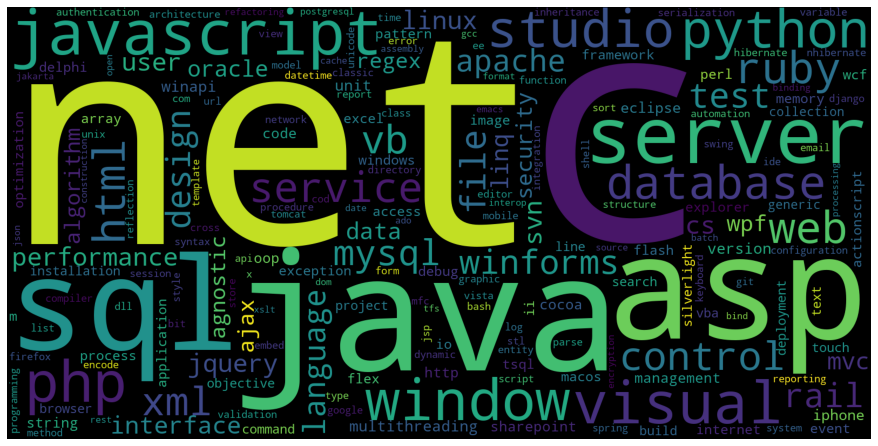

time: 4.13 s (started: 2021-12-06 15:10:10 +01:00)


In [135]:
from wordcloud import WordCloud
tag_to_count_map
tupl = dict(tag_to_count_map.items())
word_cloud = WordCloud(width=1600,height=800,).generate_from_frequencies(tupl)
plt.figure(figsize = (12,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

# Zoom 15 tags + présent

Text(0.5, 1.0, '#15 premiers')

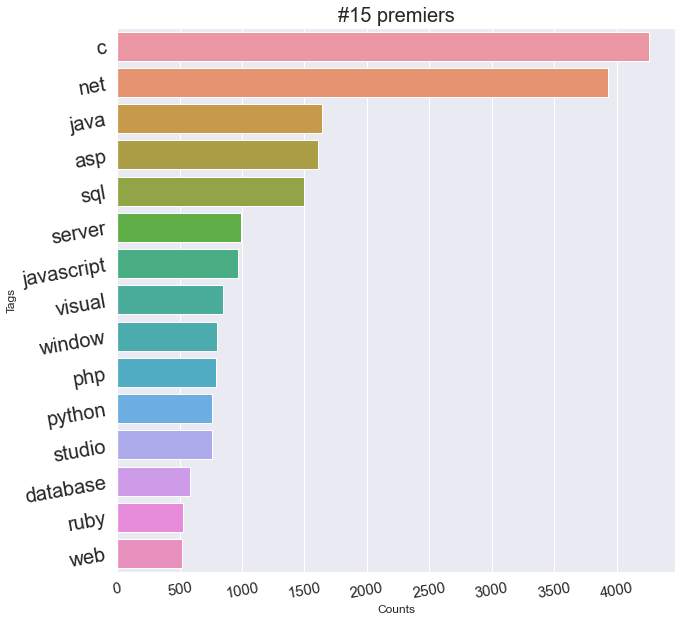

time: 428 ms (started: 2021-12-06 15:10:14 +01:00)


In [136]:
tag_df_sorted_Top_15 = tag_df_sorted.head(15)
plt.figure(figsize=(10, 10))
ax = sns.barplot(x='Counts', y='Tags', data=tag_df_sorted_Top_15, orient='h')
plt.xticks(fontsize=15, rotation=10)
plt.yticks(fontsize=20, rotation=10)
plt.title('#15 premiers', fontsize=20)

# TEST

In [139]:
y = pd.DataFrame(new_r_df['New_Tags'])
y

,New_Tags
0,web framework
1,python oop metaclass class datamodel
2,c log enterprise library application block
3,php facebook r
4,c regex
...,...
20727,net wpf xaml datatrigger
20728,python orm sqlalchemy
20729,java dataoutputstream
20730,php authentication cakephp


time: 11.2 ms (started: 2021-12-06 15:11:40 +01:00)


In [145]:
X = pd.DataFrame(new_df['Sentence'])
X = X.reset_index()
X.pop('index')
X

,Sentence
0,question intends technology agnostic kind web ...
1,python metaclasses use
2,logging lognet easy put class called log log f...
3,make facebook rss application autoupdates prov...
4,good regular expression validate text string m...
...,...
20727,datatrigger defined xaml want use several plac...
20728,starting new application looking using orm par...
20729,socket programming transmit information across...
20730,looking whole aco aro implementation want use ...


time: 15.1 ms (started: 2021-12-06 15:14:12 +01:00)


In [152]:
n_topics = 50
text = X['Sentence']

# vectorize
vectorizer_train = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)


TF_IDF_matrix = vectorizer_train.fit_transform(text)
TF_IDF_matrix.data


array([0.12672625, 0.1837562 , 0.23599462, ..., 0.18020199, 0.23805401,
       0.17417344])

time: 6.02 s (started: 2021-12-06 15:32:19 +01:00)


In [180]:
lda = LatentDirichletAllocation(n_components=77, 
                                max_iter=5, 
                                learning_method='online', 
                                learning_offset=50,
                                random_state=11).fit(TF_IDF_matrix)

time: 40.5 s (started: 2021-12-06 16:36:56 +01:00)


In [195]:

dis_top = []
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        dis_one = []
        for i in topic.argsort()[:-no_top_words - 1:-1]:
            dis_one.append(feature_names[i])
        print(dis_one)
        dis_top.append([topic_idx,dis_one ])
        print("--------------------------------------------")
        

display_topics(lda, vectorizer_train.get_feature_names(), 3)

Topic 0:
['jsp', 'implementing', 'returned']
--------------------------------------------
Topic 1:
['var', 'private', 'string']
--------------------------------------------
Topic 2:
['dll', 'runtime', 'bytes']
--------------------------------------------
Topic 3:
['wondering', 'none', 'approach']
--------------------------------------------
Topic 4:
['svn', 'kind', 'changes']
--------------------------------------------
Topic 5:
['console', 'template', 'designer']
--------------------------------------------
Topic 6:
['test', 'unit', 'tests']
--------------------------------------------
Topic 7:
['requires', 'features', 'numbers']
--------------------------------------------
Topic 8:
['date', 'way', 'want']
--------------------------------------------
Topic 9:
['list', 'task', 'li']
--------------------------------------------
Topic 10:
['image', 'images', 'img']
--------------------------------------------
Topic 11:
['asp', 'net', 'mvc']
--------------------------------------------
To

In [204]:
dis_top_df = pd.DataFrame(dis_top)
dis_top_df = dis_top_df.rename(columns={0: "Topic_ID", 1: "Topic_Word"})
dis_top_df

,Topic_ID,Topic_Word
0,0,"[jsp, implementing, returned]"
1,1,"[var, private, string]"
2,2,"[dll, runtime, bytes]"
3,3,"[wondering, none, approach]"
4,4,"[svn, kind, changes]"
...,...,...
72,72,"[sample, namespace, use]"
73,73,"[random, title, characters]"
74,74,"[command, line, os]"
75,75,"[comments, needs, returns]"


time: 16.8 ms (started: 2021-12-06 16:52:27 +01:00)


In [201]:
doc_topic = lda.transform(TF_IDF_matrix)
lst_app = []
for n in tqdm(range(doc_topic.shape[0])):
    topic_doc = doc_topic[n].argmax()
    lst_app.append([n,topic_doc])

100%|██████████| 20732/20732 [00:00<00:00, 335691.99it/s]

time: 4.7 s (started: 2021-12-06 16:48:52 +01:00)


In [202]:
doc_top_df = pd.DataFrame(lst_app)
doc_top_df = doc_top_df.rename(columns={0: "Doc_ID", 1: "Topic_ID"})
doc_top_df

,Doc_ID,Topic_ID
0,0,52
1,1,36
2,2,32
3,3,65
4,4,32
...,...,...
20727,20727,42
20728,20728,62
20729,20729,22
20730,20730,8


time: 35.6 ms (started: 2021-12-06 16:49:31 +01:00)


In [203]:
count_Df = pd.concat([doc_top_df, y], axis=1)
count_Df

,Doc_ID,Topic_ID,New_Tags
0,0,52,web framework
1,1,36,python oop metaclass class datamodel
2,2,32,c log enterprise library application block
3,3,65,php facebook r
4,4,32,c regex
...,...,...,...
20727,20727,42,net wpf xaml datatrigger
20728,20728,62,python orm sqlalchemy
20729,20729,22,java dataoutputstream
20730,20730,8,php authentication cakephp


time: 15.4 ms (started: 2021-12-06 16:51:49 +01:00)


In [291]:
result = pd.merge(count_Df, dis_top_df, on="Topic_ID")
result['Topic_W'] = [','.join(map(str, l)) for l in result['Topic_Word']]
result.pop('Topic_Word')
result['Topic_W'] = result['Topic_W'].str.replace(r',', ' ')
result

,Doc_ID,Topic_ID,New_Tags,Topic_W
0,0,52,web framework,visual studio project
1,9,52,c unit test resharper,visual studio project
2,16,52,java swing shortcut keystroke,visual studio project
3,21,52,visual studio asp classic solution,visual studio project
4,27,52,c function header,visual studio project
...,...,...,...,...
20727,7859,28,java hibernate spring strut,report hibernate status
20728,10592,5,c class template syntax friend,console template designer
20729,12811,15,c keyboard,api lib assembly
20730,20075,15,documentation assembly doxygen,api lib assembly


time: 72.9 ms (started: 2021-12-06 17:53:06 +01:00)


In [292]:
list_tst = result.New_Tags.apply(lambda txt: txt.split(' '))

list_tst_2 = result.Topic_W.apply(lambda txt: txt.split(' '))

result = pd.concat([list_tst,list_tst_2 ], axis=1, ignore_index=True)
result

,0,1
0,"[web, framework]","[visual, studio, project]"
1,"[c, unit, test, resharper]","[visual, studio, project]"
2,"[java, swing, shortcut, keystroke]","[visual, studio, project]"
3,"[visual, studio, asp, classic, solution]","[visual, studio, project]"
4,"[c, function, header]","[visual, studio, project]"
...,...,...
20727,"[java, hibernate, spring, strut]","[report, hibernate, status]"
20728,"[c, class, template, syntax, friend]","[console, template, designer]"
20729,"[c, keyboard]","[api, lib, assembly]"
20730,"[documentation, assembly, doxygen]","[api, lib, assembly]"


time: 65.4 ms (started: 2021-12-06 17:53:06 +01:00)


In [273]:
l = 0
m = 0
check_App = []
for i in tqdm(range(len(result))):
    for j in result.iloc[i][0]:
        for k in result.iloc[i][1]:
            l = l+1
            if j==k:
                m = m+1
            else:
                continue
            check_App.append([i,1])
print("Nb de comparaison ------> ", l)
print("Match ------> ", m)

100%|██████████| 20732/20732 [00:08<00:00, 2365.98it/s]

Nb de comparaison ------>  216378
Match ------>  3791
time: 8.77 s (started: 2021-12-06 17:43:55 +01:00)


In [269]:
print(m/l)

0.01752026546136853
time: 585 µs (started: 2021-12-06 17:40:05 +01:00)


In [286]:
check_App_df = pd.DataFrame(check_App)
check_App_df_1 = check_App_df.groupby([0]).sum()
check_App_df_1 = check_App_df_1.reset_index()
check_App_df_1 = check_App_df_1.rename(columns={0: "Doc_ID", 1: "Count_same"})
check_App_df_1

,Doc_ID,Count_same
0,3,2
1,8,2
2,10,2
3,16,2
4,25,2
...,...,...
2895,20724,2
2896,20726,1
2897,20727,1
2898,20728,1


time: 22.9 ms (started: 2021-12-06 17:52:13 +01:00)


In [294]:
result_1 = result.reset_index()
result_1 = result_1.rename(columns={"index": "Doc_ID"})
result_1

,Doc_ID,0,1
0,0,"[web, framework]","[visual, studio, project]"
1,1,"[c, unit, test, resharper]","[visual, studio, project]"
2,2,"[java, swing, shortcut, keystroke]","[visual, studio, project]"
3,3,"[visual, studio, asp, classic, solution]","[visual, studio, project]"
4,4,"[c, function, header]","[visual, studio, project]"
...,...,...,...
20727,20727,"[java, hibernate, spring, strut]","[report, hibernate, status]"
20728,20728,"[c, class, template, syntax, friend]","[console, template, designer]"
20729,20729,"[c, keyboard]","[api, lib, assembly]"
20730,20730,"[documentation, assembly, doxygen]","[api, lib, assembly]"


time: 26.5 ms (started: 2021-12-06 17:53:57 +01:00)


In [297]:
result_2 = pd.merge(result_1, check_App_df_1, on="Doc_ID",how='outer')
result_2 = result_2.fillna(0)
result_2

,Doc_ID,0,1,Count_same
0,0,"[web, framework]","[visual, studio, project]",0.0
1,1,"[c, unit, test, resharper]","[visual, studio, project]",0.0
2,2,"[java, swing, shortcut, keystroke]","[visual, studio, project]",0.0
3,3,"[visual, studio, asp, classic, solution]","[visual, studio, project]",2.0
4,4,"[c, function, header]","[visual, studio, project]",0.0
...,...,...,...,...
20727,20727,"[java, hibernate, spring, strut]","[report, hibernate, status]",1.0
20728,20728,"[c, class, template, syntax, friend]","[console, template, designer]",1.0
20729,20729,"[c, keyboard]","[api, lib, assembly]",0.0
20730,20730,"[documentation, assembly, doxygen]","[api, lib, assembly]",1.0


time: 45.4 ms (started: 2021-12-06 17:54:25 +01:00)


In [315]:
_sum_ = result_2.Count_same.sum()
total = 20732*3
print('accuracy / 3 tags pred', round(_sum_/total*100,2) , ' %')
print('')

accuracy / 3 tags pred 6.1  %

time: 1.24 ms (started: 2021-12-06 18:50:48 +01:00)


In [314]:
val_count['Nb_tag'] = val_count['Nb_Words'] * val_count['tag_count']
_s_u_m_ = val_count.Nb_tag.sum()
print('accuracy / total', round(_sum_/_s_u_m_*100,2) , ' %')
print('')

accuracy / total 5.26  %

time: 847 µs (started: 2021-12-06 18:50:46 +01:00)
